In [1]:
 %matplotlib inline
import sys
import numpy as np
import cv2
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt

sys.path.append("/opt/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/models/research")
sys.path.append("/opt/anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/models/research/object_detection")


from tensorflow.models.research.object_detection.utils import label_map_util
from tensorflow.models.research.object_detection.utils import visualization_utils as vis_util

In [27]:


PATH_TO_CKPT = '/home/maurice/ssd/binocular/exports/ssd_mobilenet_v1_coco_class11/frozen_inference_graph.pb'
PATH_TO_LABELS = '/home/maurice/ssd/binocular/datacrusader/generated/binocular/labels_map.pbtxt'
NUM_CLASSES = 11


def get_categories(PATH_TO_LABELS, NUM_CLASSES):
    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return category_index


def load_image_tensor(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    return img


def load_graph(PATH_TO_CKPT):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph


def make_inference(image_data, detection_graph, category_index, score_thresh=0.75):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name(
                'num_detections:0')
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_data}
            )
            image_np = image_data[0]
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                scores=np.squeeze(scores),
                category_index=category_index,
                min_score_thresh=score_thresh,
                use_normalized_coordinates=True,
                max_boxes_to_draw=None,
                line_thickness=3)

    return image_np, classes[scores > score_thresh], scores[scores > score_thresh], boxes[scores > score_thresh]


def get_prediction(image, category_index, detection_graph, score_thresh=0.5):
    image_data = load_image_tensor(image)
    prediction, classes, scores, boxes = make_inference(image_data, detection_graph, category_index, score_thresh)
    objects = Counter(classes)
    result = {category_index[k]['name']: v for k, v in objects.items()}
    print("classes length : {}".format(len(classes)))
    classes = [category_index[i]['name'] for i in classes]
    print("scores length : {}".format(len(scores)))
    print("Boxes",boxes)
    print("Classes",classes)
    main_result = []
    for i in range(len(boxes)):
        main_result.append({'name':classes[i],'box':boxes[i].tolist(),'score':int(100*scores[i])})
    result.update(dict(zip(classes, scores)))
    # result.update(dict(zip(classes, boxes)))
    results = (prediction, result)
    return prediction, main_result



In [18]:
detection_graph = load_graph(PATH_TO_CKPT)
category_index = get_categories(PATH_TO_LABELS, NUM_CLASSES)

In [19]:
category_index

{1: {'id': 1, 'name': 'ob_vitality_pink'},
 2: {'id': 2, 'name': 'ob_vitality_blue'},
 3: {'id': 3, 'name': 'ob_trizone_500'},
 4: {'id': 4, 'name': 'ob_trizone'},
 5: {'id': 5, 'name': 'ob_sensitive'},
 6: {'id': 6, 'name': 'ob_professional'},
 7: {'id': 7, 'name': 'ob_30white'},
 8: {'id': 8, 'name': 'ob_precision'},
 9: {'id': 9, 'name': 'pampers_red'},
 10: {'id': 10, 'name': 'pampers_green'},
 11: {'id': 11, 'name': 'pampers_blue'}}

In [20]:
# category_index2 = { category_index[key]:key for key,val in category_index }


TypeError: 'int' object is not iterable

In [7]:
# image = cv2.imread('/home/maurice/ssd/binocular/datacrusader/temp_data/binocular/products/test/temp_img39.jpg')
# image = cv2.imread('/home/maurice/ssd/binocular/datacrusader/temp_data/binocular/products/test/87529c32518649.568860f2ea66d.jpg')
# image = cv2.imread('/home/maurice/ssd/binocular/datacrusader/temp_data/binocular/products/test/624f6e32518649.568860f2e7c6c.jpg')
image = cv2.imread('/home/maurice/ssd/binocular/datacrusader/temp_data/binocular/b7c85350714697.56088f8d0ed31.jpg')


In [28]:
prediction, main_result = get_prediction(image_tmp, category_index, detection_graph, 0.1)



classes length : 48
scores length : 48
Boxes [[0.31237826 0.60078704 0.37630978 0.61919856]
 [0.25085393 0.7773729  0.3340114  0.8128206 ]
 [0.8250425  0.72572947 0.8937987  0.75778675]
 [0.72095704 0.7402032  0.79652643 0.77061266]
 [0.6061123  0.77559626 0.6847072  0.8111495 ]
 [0.7097085  0.70674455 0.78489107 0.737131  ]
 [0.7320554  0.8095704  0.8107159  0.8456544 ]
 [0.37512198 0.7346897  0.450627   0.7705605 ]
 [0.79067177 0.6045201  0.84470445 0.62794983]
 [0.6090708  0.8069652  0.6902592  0.8418316 ]
 [0.607805   0.6797418  0.6754379  0.7055587 ]
 [0.49690962 0.6786175  0.56327295 0.702191  ]
 [0.39437073 0.6197214  0.46805793 0.6429213 ]
 [0.67837936 0.572145   0.7447483  0.59617496]
 [0.23509014 0.8092993  0.31793416 0.8447898 ]
 [0.2855712  0.67410845 0.35947093 0.705159  ]
 [0.7180888  0.41654295 0.7765148  0.4421035 ]
 [0.8386178  0.7605549  0.9068452  0.7941462 ]
 [0.6089108  0.70860773 0.6775607  0.7359225 ]
 [0.6877537  0.6037912  0.75227356 0.6266584 ]
 [0.36891904 0.

In [22]:
image_tmp = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

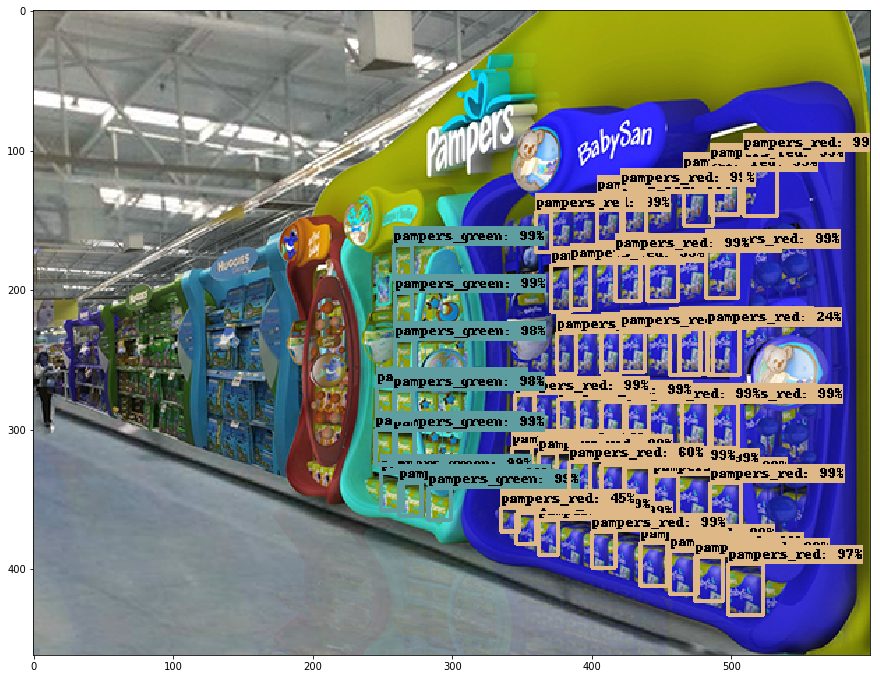

In [30]:
plt.figure(figsize=(15,15))
plt.imshow(prediction)